In [1]:
from sense_hat import SenseHat
import matplotlib.pyplot as plt
import numpy as np
import time, json

In [2]:
sense = SenseHat()
sense.set_rotation(180)
sense.show_message("PPT 2022")

In [81]:
def record_pendulum(mode='gyro_raw',max_seconds=10):
    data = {'time':[],'x':[],'y':[],'z':[]}
    print("Press joystick to start measuring")
    event = sense.stick.wait_for_event(emptybuffer=True)
    time.sleep(1)
    start_time = time.time()
    elapsed=0
    while elapsed<max_seconds:
        acc = sense.__getattribute__(mode)
        elapsed = time.time()-start_time
        data['time'].append(elapsed)
        for f in ['x','y','z']:
            data[f].append(acc[f])
        remaining=int(max_seconds-elapsed)
        if(remaining>9):
            sense.show_letter("O")
        else:
            sense.show_letter(str(remaining))
    return data

In [67]:
def plot_data(data):
    f,ax = plt.subplots()
    t = np.array(data['time'])
    r2 = np.zeros(len(t))
    for f in ['x','y','z']:
        ax.plot(t,np.array(data[f]),label=f)
    ax.legend()
    #ax.set_yscale('log')
    
def save_data(data,fname):
    json.dump(data,open(fname,'w'))
    
def load_data(fname):
    return json.load(open(fname,'r'))

In [35]:
gyros_data = record_pendulum('gyro_raw',max_seconds=20)

Press joystick to start measuring


In [66]:
save_data(gyros_data,'data.json')

In [232]:
load_data('data.json') == gyros_data

True

In [5]:
gyros_data=load_data('data.json')

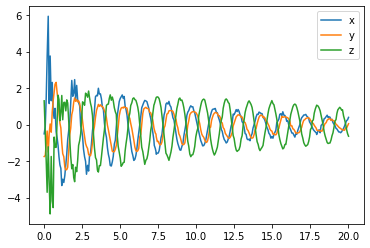

In [68]:
plot_data(gyros_data)

In [76]:
t,y = np.array(gyros_data['time']),np.array(gyros_data['y'])

In [77]:
import scipy.optimize

def sinfunc(t, A, w, p, c, d=0):  return A * np.sin(w*t + p)*np.exp(-t*d) + c

def fit_sin(t,y, d_guess=0.):
    guess = np.array([
        np.std(y) * np.sqrt(2),# guess amplitude
        1.*2*np.pi,            # guess ang frequency - better guess might be f from FFT (see here: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy)
        0.,                    # guess phase
        np.mean(y),            # guess offset
        d_guess,               # guess damping constant
    ])

    popt, pcov = scipy.optimize.curve_fit(sinfunc, t, y, p0=guess)
    A, w, p, c, d = popt
    #print(popt)
    #return {'fitfunc':lambda t: A*np.sin(w*t+p)*np.exp(-t*d)+c,'popt':popt,'pcov':pcov}
    return {'fitfunc':lambda t: sinfunc(t,A,w,p,c,d),'popt':popt,'pcov':pcov}

Durch Loesen der Bewegungsgleichungen des Fadenpendels ergibt sich fuer die Kreisfrequenz $\omega_0 = \sqrt{\frac{g}{l}}$

length of pendulum if g=9.81m/s^2 -> l=0.5706+-0.0010 m
g if length of pendulum l=59cm -> g=10.2123+-0.0186 m/s^2


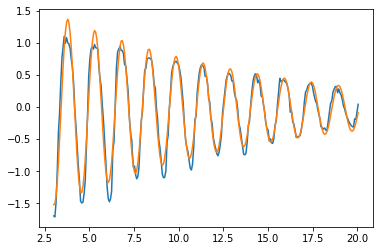

In [80]:
f,ax = plt.subplots()
start_time = 3
start_index = np.argmax(t>start_time)

t_ = t[start_index:]
y_ = y[start_index:]

ax.plot(t_,y_,label='data')

fit = fit_sin(t_,y_,d_guess=0.5)
fitfunc = np.vectorize(fit['fitfunc'])

ax.plot(t_,fitfunc(t_),label='fit')
#print(fit)
w = fit['popt'][1]
werr = np.sqrt(fit['pcov'][1,1])
l_ = 2*0.297
g_ = 9.81

g = w**2*l_
gerr = 2*w*l_*werr

l = g_/w**2
lerr = np.sqrt((-2.*g_/w**3*werr)**2)


print(f'length of pendulum if g=9.81m/s^2 -> l={l:.4f}+-{lerr:.4f} m')
print(f'g if length of pendulum l={int(100*l_)}cm -> g={g:.4f}+-{gerr:.4f} m/s^2')


In [46]:
print('postfit parameters with uncertainties from cov-matrix')
print('\n'.join([f"{fit['popt'][ip]:.2f} +- {e:.2f}" for ip,e in enumerate(np.sqrt(np.diag(fit['pcov'])))]))

postfit parameters with uncertainties from cov-matrix
3.07 +- 0.11
4.09 +- 0.01
-0.42 +- 0.04
-0.05 +- 0.03
0.11 +- 0.01
